# Heart Attack Analysis and Prediction (Catboost) (beginner)

![](https://i.ibb.co/bH86zpn/EKG-Heart-concept-ML1701-ts484297336.png)

A heart attack occurs when the flow of blood to the heart is blocked.  

The blockage is most often a buildup of fat, cholesterol and other substances, which form a plaque in the arteries that feed the heart (coronary arteries).  


A heart attack, also called a **myocardial infarction**, can be **fatal** 

Lets try to analyze data set and find some insights to predict heart attacks

## General information about data

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from catboost import CatBoostClassifier
from catboost import Pool, cv
import warnings
warnings.filterwarnings("ignore")


### Loading and previewing data

In [2]:
heart = pd.read_csv('../input/heart-attack-analysis-prediction-dataset/heart.csv')
o2_sat = pd.read_csv('../input/heart-attack-analysis-prediction-dataset/o2Saturation.csv')

In [3]:
heart.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1



We have a dateframe with the following features:

- `Age`: Age of the patient
- `Sex` : Sex of the patient *(1 = male; 0 = female)*
- `exang`: exercise induced angina (1 = yes; 0 = no)
- `ca`: number of major vessels (0-3)
- `cp` : Chest Pain type chest pain type

    -- Value 1: typical angina. 

    -- Value 2: atypical angina. 

    -- Value 3: non-anginal pain. 

    -- Value 4: asymptomatic. 

- `trtbps` : resting blood pressure (in mm Hg): *normal reading would be any blood pressure below 120/80 mm Hg and above 90/60 mm Hg in an adult*. 

- `chol` : cholestoral in mg/dl fetched via BMI sensor: *normal range is <200 mg/dL*. 

- `fbs` : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- `rest_ecg` : resting electrocardiographic results

    -- Value 0: normal

    -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)

    -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

- `thalach` : maximum heart rate achieved
- `target` : 0= less chance of heart attack 1= more chance of heart attack

In [4]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
o2_sat.head()

,98.6
0,98.6
1,98.6
2,98.6
3,98.1
4,97.5


In [6]:
o2_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   98.6    3585 non-null   float64
dtypes: float64(1)
memory usage: 28.1 KB


A normal level of oxygen is usually 95% or higher. Some people with chronic lung disease or sleep apnea can have normal levels around 90%.

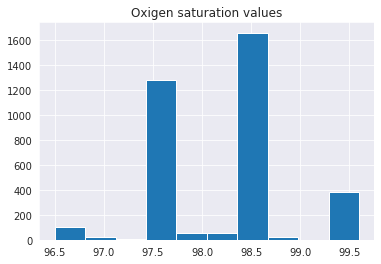

In [7]:
o2_sat.hist()
plt.title('Oxigen saturation values')
plt.show()

In [8]:
o2_sat.value_counts()

98.6
98.6    1661
97.5     704
97.6     579
99.6     359
96.5     104
98.2      32
98.0      29
97.9      25
98.1      23
99.3      21
98.8      13
97.1       9
97.0       9
98.9       8
96.9       5
97.2       3
98.3       1
dtype: int64

We can see, that oxygen saturation tab consist of normal values of oxigen in blood. We will work only with `heart`-set further. 

Let check duplicates

In [9]:
heart.duplicated().sum()

1

We have the only one duplicated object here - we can drop it

In [10]:
df = heart.drop_duplicates().reset_index(drop=True).copy()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    int64  
 1   sex       302 non-null    int64  
 2   cp        302 non-null    int64  
 3   trtbps    302 non-null    int64  
 4   chol      302 non-null    int64  
 5   fbs       302 non-null    int64  
 6   restecg   302 non-null    int64  
 7   thalachh  302 non-null    int64  
 8   exng      302 non-null    int64  
 9   oldpeak   302 non-null    float64
 10  slp       302 non-null    int64  
 11  caa       302 non-null    int64  
 12  thall     302 non-null    int64  
 13  output    302 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,302.0,54.420530,9.047970,29.0,48.00,55.5,61.00,77.0
sex,302.0,0.682119,0.466426,0.0,0.00,1.0,1.00,1.0
cp,302.0,0.963576,1.032044,0.0,0.00,1.0,2.00,3.0
trtbps,302.0,131.602649,17.563394,94.0,120.00,130.0,140.00,200.0
chol,302.0,246.500000,51.753489,126.0,211.00,240.5,274.75,564.0
fbs,302.0,0.149007,0.356686,0.0,0.00,0.0,0.00,1.0
restecg,302.0,0.526490,0.526027,0.0,0.00,1.0,1.00,2.0
thalachh,302.0,149.569536,22.903527,71.0,133.25,152.5,166.00,202.0
exng,302.0,0.327815,0.470196,0.0,0.00,0.0,1.00,1.0
oldpeak,302.0,1.043046,1.161452,0.0,0.00,0.8,1.60,6.2


### Conclusion


At first glance, we do not see anomalies in the data. There are no missing values, duplicates are removed. There is no need to convert data to other types. Let's get started with exploratory data analysis. But before that let us devide set to train and test and hide our test data to prevent data snooping bias

## Dividing data

For dividing data we will use `train_test_split` from `scikit-Learn` library. Or we can use pandas method `sample()` with frac and random state.


PS. you can do it also in this way:

`train = df.sample(frac=0.8,random_state=42).copy()`. 

`test = df[~df.index.isin(train.index)].copy()`


we will work with `scikit-Learn`


In [13]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

Check the lens

In [14]:
len(train_set)

241

In [15]:
len(test_set)

61

In [16]:
len(train_set) + len(test_set) == len(df)

True

In my opinion iti is better to hide test now, before EDA - we have no NaN, we have no duplicates - in this case i decided to hide test to prevent snooping bias.  
Now we have to sets - train for our model and test


## Exploratory data analysis

In [17]:
train_set.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
132,42,1,1,120,295,0,1,162,0,0.0,2,0,2,1
202,68,1,2,180,274,1,0,150,1,1.6,1,0,3,0
196,67,1,0,125,254,1,1,163,0,0.2,1,2,3,0
75,55,0,1,135,250,0,0,161,0,1.4,1,0,2,1
176,64,1,2,140,335,0,1,158,0,0.0,2,0,2,0


Let us plot hist of featires to see all values, that we have


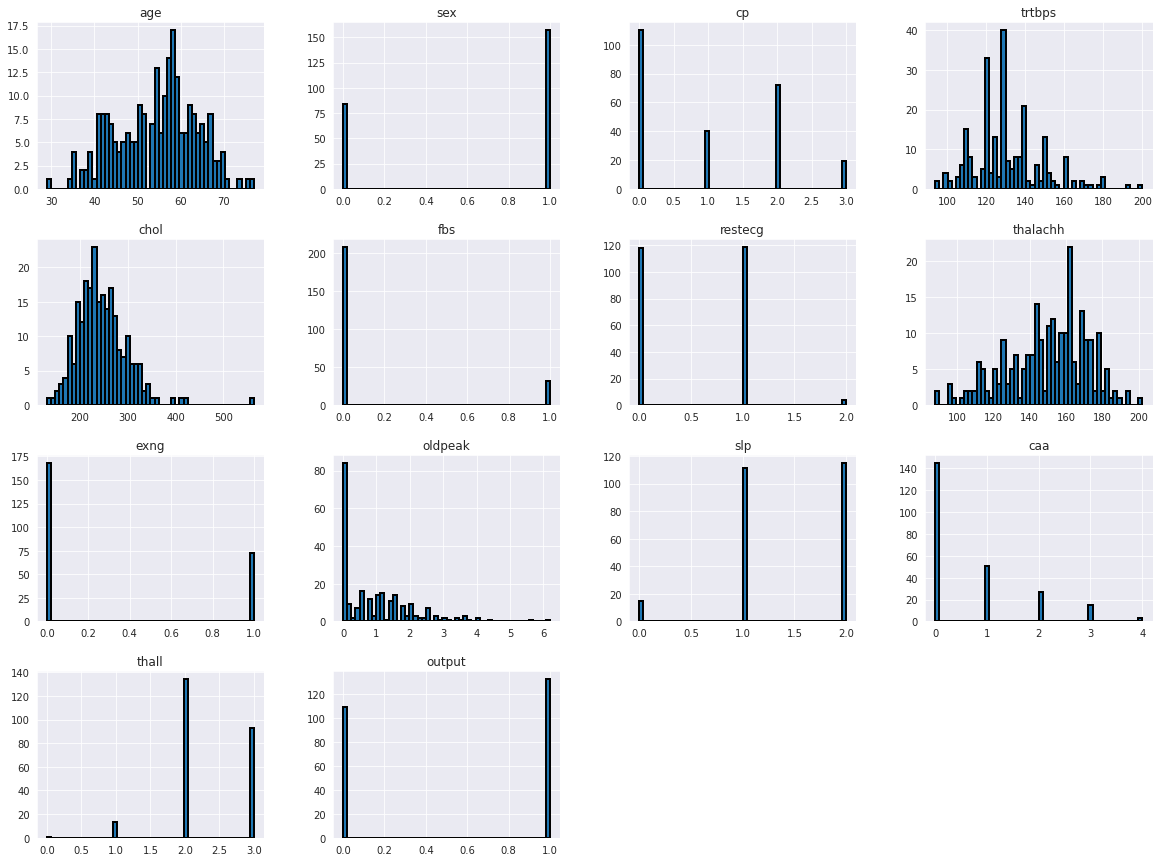

In [18]:
train_set.hist(bins=50, figsize=(20,15), edgecolor='black', linewidth=2)
plt.show()

We have `age` feature with many values. It is

In [19]:
train_set['age_group'] = pd.qcut(train_set['age'], 5)

In [20]:
train_set.groupby('age_group')['output'].agg(['count', 'mean']).sort_values(by='mean', ascending=False)

,count,mean
age_group,,
"(28.999, 45.0]",51,0.745098
"(45.0, 53.0]",49,0.653061
"(62.0, 77.0]",48,0.520833
"(53.0, 58.0]",60,0.466667
"(58.0, 62.0]",33,0.272727


We see, that the highest amount of heart attack is in group of 29-44 years old. maybe it is due to irregular work, stress, poor nutrition, and the abuse of fast food smkoing and etc - a pretty young disease.  

let us group by sex and age

In [21]:
train_set.groupby(['age_group', 'sex'])['output'].agg(['count', 'mean'])

count      mean
age_group      sex                 
(28.999, 45.0] 0       16  0.937500
               1       35  0.657143
(45.0, 53.0]   0       14  0.928571
               1       35  0.542857
(53.0, 58.0]   0       21  0.666667
               1       39  0.358974
(58.0, 62.0]   0       12  0.333333
               1       21  0.238095
(62.0, 77.0]   0       21  0.809524
               1       27  0.296296

In [22]:
train_set.groupby(['sex'])['output'].agg(['count', 'mean'])

,count,mean
sex,,
0,84,0.75000
1,157,0.43949


The main risk factor for the development of myocardial infarction is arterial hypertension. And it is among female that this disease occurs quite often

also we can see, that the count of male with heart breaks is bigger than femal. One of the reasons for this is that fewer atherosclerotic plaques form in the vessels of the female body, and therefore there is less likelihood of blood clots in the arteries of the heart.

Summary, heart aches more offen affect male, but with age it is affect more femal

  0%|          | 0/3 [00:00<?, ?it/s]

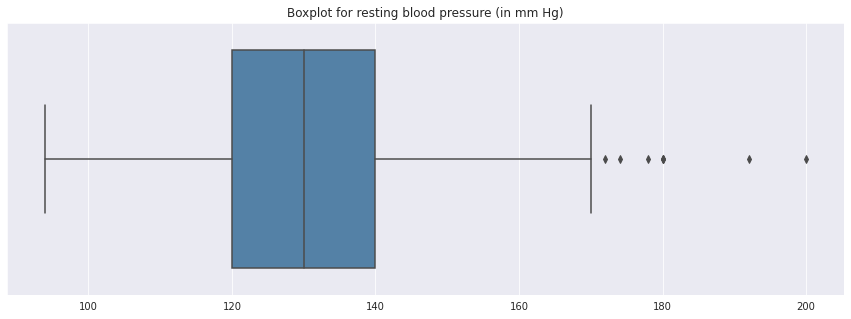

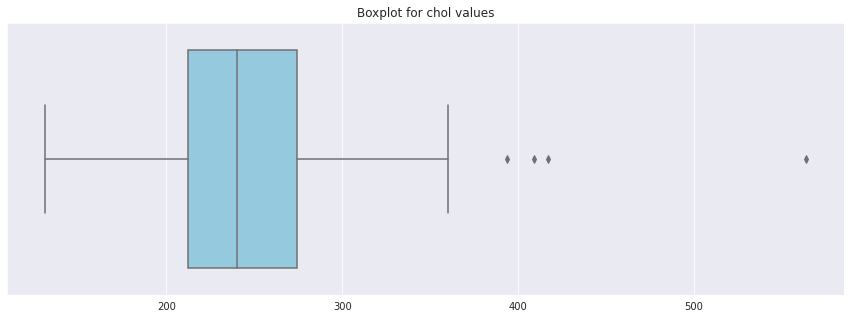

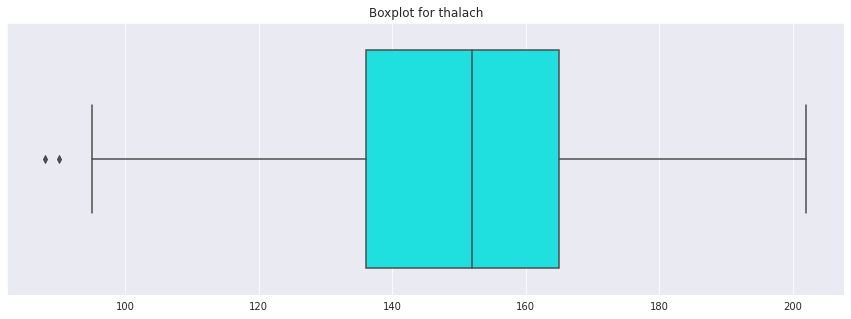

In [23]:

columns_list = ['trtbps', 'chol', 'thalachh']
title_list = ['Boxplot for resting blood pressure (in mm Hg)', 'Boxplot for chol values', 
              'Boxplot for thalach']

color_list=['steelblue', 'skyblue', 'cyan']


for i in tqdm(range(len(columns_list))):
    q75 = train_set[columns_list[i]].quantile([.75])
    q25 = train_set[columns_list[i]].quantile([.25])
    iqr = q75 - q25
    low_range = q25 - (1.5 * iqr)
    high_range = q75 + (1.5 * iqr)
    plt.figure(figsize=(15, 5))
    sns.boxplot(train_set[columns_list[i]], color=color_list[i])
    plt.xlim = (low_range, high_range)
    plt.title(title_list[i])
    plt.xlabel('')
    plt.show()


We have no big outliners or anomaly

In [24]:
train_set.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,age_group
132,42,1,1,120,295,0,1,162,0,0.0,2,0,2,1,"(28.999, 45.0]"
202,68,1,2,180,274,1,0,150,1,1.6,1,0,3,0,"(62.0, 77.0]"
196,67,1,0,125,254,1,1,163,0,0.2,1,2,3,0,"(62.0, 77.0]"
75,55,0,1,135,250,0,0,161,0,1.4,1,0,2,1,"(53.0, 58.0]"
176,64,1,2,140,335,0,1,158,0,0.0,2,0,2,0,"(62.0, 77.0]"


In [25]:
train_set['trtbps_group'] = pd.qcut(train_set['trtbps'], 5)

In [26]:
train_set.groupby(['trtbps_group'])['output'].agg(['count', 'mean'])

,count,mean
trtbps_group,,
"(93.999, 120.0]",81,0.617284
"(120.0, 125.0]",17,0.352941
"(125.0, 132.0]",50,0.580000
"(132.0, 144.0]",45,0.622222
"(144.0, 200.0]",48,0.395833


In [27]:
train_set['chol_group'] = pd.qcut(train_set['chol'], 5)

In [28]:
train_set.groupby(['chol_group'])['output'].agg(['count', 'mean'])

,count,mean
chol_group,,
"(130.999, 204.0]",50,0.600000
"(204.0, 230.0]",47,0.574468
"(230.0, 253.0]",48,0.645833
"(253.0, 283.0]",48,0.395833
"(283.0, 564.0]",48,0.520833


We can see that level of cholesterin and resting blood pressure (in mm Hg) is affects frequency of heart attacks

### Conclusion


The main risk factor for the development of myocardial infarction is arterial hypertension. And it is among female that this disease occurs quite often

also we can see, that the count of male with heart breaks is bigger than female. One of the reasons for this is that fewer atherosclerotic plaques form in the vessels of the female body, and therefore there is less likelihood of blood clots in the arteries of the heart.

Summary, heart aches more offen affect male, but with age it is affect more femal

We can see that level of cholesterin and resting blood pressure (in mm Hg) is affects frequency of heart attacks


In summary age, gender, chol level and resting blood pressure is affect heart attacks

## Feature engeneering

Lets split our train set for features and target

In [29]:
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]

In [30]:
train_features, train_target = split_data(train_set, 'output')

In [31]:
train_features = train_features.drop(['age_group',	'trtbps_group',	'chol_group'], axis=1)

In [32]:
train_features.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
132,42,1,1,120,295,0,1,162,0,0.0,2,0,2
202,68,1,2,180,274,1,0,150,1,1.6,1,0,3
196,67,1,0,125,254,1,1,163,0,0.2,1,2,3
75,55,0,1,135,250,0,0,161,0,1.4,1,0,2
176,64,1,2,140,335,0,1,158,0,0.0,2,0,2


## Train model and tune

Let us try to choose parametrs of model via `GridSearchCV`

In [33]:
cat_model = CatBoostClassifier()
params = {'iterations': [100, 200, 500],
          'depth': [4, 5, 6],
          'loss_function': ['Logloss', 'CrossEntropy'],
          'l2_leaf_reg': np.logspace(-20, -19, 3),
          'leaf_estimation_iterations': [10],
          'logging_level':['Silent'],
          'random_seed': [42]
         }
scorer = make_scorer(accuracy_score)
clf_grid = GridSearchCV(estimator=cat_model, param_grid=params, scoring=scorer, cv=5)

Train our model on train set

In [34]:
clf_grid.fit(train_features, train_target)
best_param = clf_grid.best_params_
best_param

{'depth': 5,
 'iterations': 500,
 'l2_leaf_reg': 1e-20,
 'leaf_estimation_iterations': 10,
 'logging_level': 'Silent',
 'loss_function': 'Logloss',
 'random_seed': 42}

Now we have can save the best model with the best parametrs and train it on train_pool for crossvalidation

In [35]:
model = CatBoostClassifier(depth= 5,
                           iterations = 500,
                           l2_leaf_reg= 1e-20,
                           leaf_estimation_iterations= 10,
                           logging_level= 'Silent',
                           loss_function= 'Logloss',
                           random_seed= 42)

In [36]:
cat_features = [0]
xtrain, xval, ytrain, yval = train_test_split(
                            train_features, train_target, 
                            train_size=0.8,random_state=42
                            )
train_pool = Pool(xtrain, ytrain, cat_features=cat_features)

params = {'depth': 5,
          'iterations': 500,
          'l2_leaf_reg': 1e-20,
          'leaf_estimation_iterations': 10,
          'logging_level': 'Silent',
          'loss_function': 'Logloss',
          'random_seed': 42}


# Unfortunately plotting works only in Jupiter
# scores = cv(train_pool,
#             params,
#             fold_count=2, 
#             plot="True")

In [37]:
model.fit(train_pool, eval_set=(xval, yval))

Now it is time to our test set

In [38]:
test_features, test_target = split_data(test_set, 'output')
test_features.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
179,55,1,0,132,353,0,1,132,1,1.2,1,1,3
228,64,1,2,125,309,0,1,131,1,1.8,1,0,3
111,57,1,2,150,126,1,1,173,0,0.2,2,1,3
246,66,1,1,160,246,0,1,120,1,0.0,1,3,1
60,71,0,2,110,265,1,0,130,0,0.0,2,1,2


Now we can test our model on test set

In [39]:
test_predictions = model.predict(test_features)
test_acc = accuracy_score(test_target, test_predictions)
test_f1 = f1_score(test_target, test_predictions)


print("Accuracy")
print("Test set:", test_acc)
print("F1-score")
print("Test set:", test_f1)

Accuracy
Test set: 0.8524590163934426
F1-score
Test set: 0.8615384615384615


And senity test:

In [40]:
(df['output'].value_counts()/df.shape[0]).to_frame()

,output
1,0.543046
0,0.456954


Our model better than random. We can try it on another set if we have

# Conclusion

Know your blood pressure. High blood pressure is usually not accompanied by any symptoms, but it is one of the main causes of sudden stroke or heart attack. Check your blood pressure and know your numbers. If your blood pressure is high, you need to change your lifestyle - switch to a healthy diet, reduce your salt intake, and increase your levels of physical activity. You may need to take medication to control your blood pressure.


Elevated blood cholesterol levels increase the risk of heart attacks and strokes. It is necessary to control blood cholesterol levels with a healthy diet and, if necessary, appropriate medications

take care of yourself and loved ones